# Model 1:

In [2]:

#! pip3 install auto-sklearn

In [3]:
import os
os.chdir('..')

In [4]:
import pandas as pd
import os
import numpy as np
RNDSEED = np.random.seed(39)
PRECISION = 4 # 3 of digits to keep after the decimal point
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, cohen_kappa_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
RUNNING_ON_COLAB = False # we assume running on CoLab! Change to False if running locally.

*italicized text*

In [5]:
## mount gdrive
#from google.colab import drive#
#drive.mount("/content/gdrive")

In [6]:
# If running locally, define current working path
path = os.getcwd()

# If Google colab
if RUNNING_ON_COLAB:
    path = "/content/gdrive/My Drive/Colab Notebooks/RandomForest_FeatureData"

print(path)

# define current data path. This is after we did classification. We have done some
# cleaning already.
data_path = path + '/fl_testbed/version2/data/initial'
print(data_path)
#/home/jose/FL_AM_Defect-Detection
#/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial

/home/jose/FL_AM_Defect-Detection
/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial


## Play code

<font color=cyan>The key is to transform the time column! </font>


In [7]:
!cd '/home/jose/FL_AM_Defect-Detection/notebooks/fl_testbed/version2/data/initial' && ls

/bin/bash: line 0: cd: /home/jose/FL_AM_Defect-Detection/notebooks/fl_testbed/version2/data/initial: No such file or directory


In [8]:
## start - play code
print(data_path)
csv_file = data_path + '/grouped.combined_offset_misalignment.csv'
df_temp = pd.read_csv(csv_file, chunksize=50000) 
df = pd.concat(df_temp, ignore_index=True)

/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial


In [9]:
print(df.columns)

Index(['Unnamed: 0', 'wf_start_time', 'S1_CrestFactor_g~g', 'S1_DerivedPeak_g',
       'S1_Peak~Peak_g', 'S1_RMS_g', 'S1_TruePeak_g', 'S1_HighFrequency_grms',
       'S1_Kurtosis_g~g', 'S2_CrestFactor_g~g', 'S2_DerivedPeak_g',
       'S2_Peak~Peak_g', 'S2_RMS_g', 'S2_TruePeak_g', 'S2_HighFrequency_grms',
       'S2_Kurtosis_g~g', 'S1_temp', 'status', 'rul'],
      dtype='object')


In [10]:
df.head(5)

,Unnamed: 0,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,0,2022-08-30 19:17:41.000007,2.9679,0.1485,0.6232,0.1050,0.3116,0.0303,2.3544,3.1791,0.4064,1.7640,0.2874,0.9136,0.2825,2.6123,72.5867,6.25mm_Offset,176049.0
1,1,2022-08-30 19:17:42.000007,3.0104,0.1511,0.6261,0.1069,0.3217,0.0310,2.3787,3.1860,0.4075,1.7210,0.2882,0.9180,0.2853,2.5937,72.5893,6.25mm_Offset,176048.0
2,2,2022-08-30 19:17:43.000007,3.2165,0.1611,0.6889,0.1139,0.3664,0.0309,2.3040,3.0295,0.4087,1.6775,0.2890,0.8755,0.2840,2.5947,72.5610,6.25mm_Offset,176047.0
3,3,2022-08-30 19:17:44.000007,3.1404,0.1388,0.6156,0.0981,0.3081,0.0309,2.4416,3.1823,0.4082,1.7048,0.2886,0.9185,0.2841,2.5852,72.5600,6.25mm_Offset,176046.0
4,4,2022-08-30 19:17:45.000007,3.4300,0.1520,0.6706,0.1075,0.3686,0.0302,2.3783,3.1616,0.4062,1.7570,0.2873,0.9082,0.2830,2.6230,72.5711,6.25mm_Offset,176045.0


In [11]:
#238722
#DO NOT FORGET SORT VALUES
df1=df.loc[0:238721].sort_values(by='wf_start_time').reset_index()
df2=df.loc[0+238722:0+238722+238722-1].sort_values(by='wf_start_time').reset_index()
df3=df.loc[0+238722+238722:].sort_values(by='wf_start_time').reset_index()

In [12]:
lists=[]
for df in [df1,df2,df3]:
    # Let's find the youngest & oldest timestamp

    df['wf_start_time'] = pd.to_datetime(df['wf_start_time']) # make sure it is datetime

    youngest = min(df.wf_start_time)
    oldest = max(df.wf_start_time)
    print(youngest)
    print(oldest)
    span = oldest - youngest
    print(span)
    print(span.total_seconds())

    ## Using Oldest - current to determine the RUL
    df['rul'] = df['wf_start_time'].apply(lambda x: (oldest - x).total_seconds())
    lists.append(df)


2022-08-09 14:03:22.000007
2022-09-01 20:11:50.000007
23 days 06:08:28
2009308.0
2022-08-09 14:03:22.000007
2022-09-01 20:11:50.000007
23 days 06:08:28
2009308.0
2022-08-09 14:03:22.000007
2022-09-01 20:11:50.000007
23 days 06:08:28
2009308.0


# ONLY ONE SET OF SIGNALS!

In [13]:
df=pd.concat(lists[-1:],ignore_index=True)

In [14]:
df.shape

(238722, 20)

In [15]:
# drop Unnamed columns
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]


# SMALLER SET!

In [16]:
# df=df[['index','wf_start_time','S1_DerivedPeak_g','S1_TruePeak_g','S2_HighFrequency_grms','S2_Kurtosis_g~g','status','rul']]

In [17]:
df.loc[0:238721]


,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,591557,2022-08-09 14:03:22.000007,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,No_Offset,2009308.0
1,591558,2022-08-09 14:03:23.000007,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,No_Offset,2009307.0
2,591559,2022-08-09 14:03:24.000007,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,No_Offset,2009306.0
3,591560,2022-08-09 14:03:25.000007,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,No_Offset,2009305.0
4,591561,2022-08-09 14:03:26.000007,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,No_Offset,2009304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238717,643079,2022-09-01 20:11:29.000007,2.5083,0.6880,2.3624,0.4865,1.2203,0.4834,2.1624,3.5082,0.2728,1.2713,0.1929,0.6767,0.1447,2.7364,73.5386,12.7mm_Offset,21.0
238718,643080,2022-09-01 20:11:30.000007,2.3925,0.6879,2.2706,0.4864,1.1638,0.4837,2.1555,3.2138,0.2856,1.2836,0.2020,0.6491,0.1457,2.7667,73.5767,12.7mm_Offset,20.0
238719,643081,2022-09-01 20:11:31.000007,5.7067,0.2556,2.0422,0.1808,1.0315,0.0308,13.5090,5.3715,0.1918,1.3841,0.1356,0.7285,0.0184,3.9787,73.5347,12.7mm_Offset,19.0
238720,643082,2022-09-01 20:11:32.000007,4.2261,0.0406,0.2402,0.0287,0.1215,0.0115,3.1910,4.3151,0.1361,0.7445,0.0963,0.4154,0.0036,3.2765,73.5728,12.7mm_Offset,18.0


In [18]:
df.loc[0+238722:0+238722+238722-1]


,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul


In [19]:
df.loc[0+238722+238722:]

,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul


In [20]:
# df.head(5)

In [21]:
df.columns

Index(['index', 'wf_start_time', 'S1_CrestFactor_g~g', 'S1_DerivedPeak_g',
       'S1_Peak~Peak_g', 'S1_RMS_g', 'S1_TruePeak_g', 'S1_HighFrequency_grms',
       'S1_Kurtosis_g~g', 'S2_CrestFactor_g~g', 'S2_DerivedPeak_g',
       'S2_Peak~Peak_g', 'S2_RMS_g', 'S2_TruePeak_g', 'S2_HighFrequency_grms',
       'S2_Kurtosis_g~g', 'S1_temp', 'status', 'rul'],
      dtype='object')

In [22]:
# save back
#df.to_csv(csv_file)

## saved more than 50% space!

In [23]:
# csv_file

In [24]:
# os.path.basename(os.path.dirname(csv_file))

In [25]:
## end - play code

## Util - add RUL column

In [26]:
# csv_file = data_path + '/combined_offset_misalignment.csv'
# df_temp = pd.read_csv(csv_file, chunksize=50000) 
# df = pd.concat(df_temp, ignore_index=True)

In [27]:
# # Let's find the youngest & oldest timestamp

# df['wf_start_time'] = pd.to_datetime(df['wf_start_time']) # make sure it is datetime

# youngest = min(df.wf_start_time)
# oldest = max(df.wf_start_time)
# print(youngest)
# print(oldest)
# span = oldest - youngest
# print(span)
# print(span.total_seconds())

# ## Using Oldest - current to determine the RUL
# df['rul'] = df['wf_start_time'].apply(lambda x: (oldest - x).total_seconds())

In [28]:
# # save back with RUL
# df.to_csv(data_path + '/combined_offset_misalignment_with_RUL.csv')


In [29]:
# df.head()

In [30]:
df.loc[0:238721]


,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,591557,2022-08-09 14:03:22.000007,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,No_Offset,2009308.0
1,591558,2022-08-09 14:03:23.000007,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,No_Offset,2009307.0
2,591559,2022-08-09 14:03:24.000007,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,No_Offset,2009306.0
3,591560,2022-08-09 14:03:25.000007,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,No_Offset,2009305.0
4,591561,2022-08-09 14:03:26.000007,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,No_Offset,2009304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238717,643079,2022-09-01 20:11:29.000007,2.5083,0.6880,2.3624,0.4865,1.2203,0.4834,2.1624,3.5082,0.2728,1.2713,0.1929,0.6767,0.1447,2.7364,73.5386,12.7mm_Offset,21.0
238718,643080,2022-09-01 20:11:30.000007,2.3925,0.6879,2.2706,0.4864,1.1638,0.4837,2.1555,3.2138,0.2856,1.2836,0.2020,0.6491,0.1457,2.7667,73.5767,12.7mm_Offset,20.0
238719,643081,2022-09-01 20:11:31.000007,5.7067,0.2556,2.0422,0.1808,1.0315,0.0308,13.5090,5.3715,0.1918,1.3841,0.1356,0.7285,0.0184,3.9787,73.5347,12.7mm_Offset,19.0
238720,643082,2022-09-01 20:11:32.000007,4.2261,0.0406,0.2402,0.0287,0.1215,0.0115,3.1910,4.3151,0.1361,0.7445,0.0963,0.4154,0.0036,3.2765,73.5728,12.7mm_Offset,18.0


In [31]:
df.loc[0+238722:0+238722+238722-1]


,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul


In [32]:
df.loc[0+238722+238722:] #NOW THIS IS VALIDATION DATA

,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul


## RF Regression

In [33]:
## Common imports
import pandas as pd
import numpy as np
import csv
import os

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, cohen_kappa_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error
# from pandas_ml import ConfusionMatrix

import matplotlib
import matplotlib.pyplot as plt
plt.style.available
%matplotlib inline

# to make this notebook's output stable across runs
RNDSEED = np.random.seed(39)

### Exploring the data a bit & prep the df

In [34]:
# ## future, let's read the file
# csv_file = data_path + '/combined_offset_misalignment_with_RUL.csv'
# df_temp = pd.read_csv(csv_file, chunksize=50000) 
# big_df = pd.concat(df_temp)

In [35]:
#df = big_df # reset 

# drop unwanted cols
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))] # drop Unnamed
df = df[df.columns.drop(list(df.filter(regex='wf_start_time')))] # drop time column
#df = df[df.columns.drop(list(df.filter(regex='status')))] # drop status column
df = df[df.columns.drop(list(df.filter(regex='index')))] # drop status column



# Map OFFSET TYPE OF ERROR

In [36]:
status_map = {
    "No_Offset": 0,
    "1mm_Offset": 1,
    "3mm_Offset": 2,
    "6.25mm_Offset": 3,
    "12.7mm_Offset": 4,
}

df["status"] = df["status"].map(status_map)

In [37]:
df.shape

(238722, 17)

In [38]:
df.columns

Index(['S1_CrestFactor_g~g', 'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g',
       'S1_TruePeak_g', 'S1_HighFrequency_grms', 'S1_Kurtosis_g~g',
       'S2_CrestFactor_g~g', 'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g',
       'S2_TruePeak_g', 'S2_HighFrequency_grms', 'S2_Kurtosis_g~g', 'S1_temp',
       'status', 'rul'],
      dtype='object')

In [39]:
# Get X & y
# Naming convention: X as predictors; y as response.
from sklearn.model_selection import train_test_split

y = df[['status','rul']] # pop response


#STANDARIZING
min_max_scaler=MinMaxScaler()
y=min_max_scaler.fit_transform(y)


X = df.drop('rul',axis = 1) # drop response

print (X.shape)
print (X.columns)

(238722, 16)
Index(['S1_CrestFactor_g~g', 'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g',
       'S1_TruePeak_g', 'S1_HighFrequency_grms', 'S1_Kurtosis_g~g',
       'S2_CrestFactor_g~g', 'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g',
       'S2_TruePeak_g', 'S2_HighFrequency_grms', 'S2_Kurtosis_g~g', 'S1_temp',
       'status'],
      dtype='object')


In [40]:
## true orignal ones
# data split

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = RNDSEED)

# Use the same function above for the validation set
X_train, X_vals, y_train, y_vals = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= RNDSEED,shuffle=False) # 0.25 x 0.8 = 0.2




In [41]:
y_test.shape

(47745, 2)

In [42]:
X_train.dtypes


S1_CrestFactor_g~g       float64
S1_DerivedPeak_g         float64
S1_Peak~Peak_g           float64
S1_RMS_g                 float64
S1_TruePeak_g            float64
S1_HighFrequency_grms    float64
S1_Kurtosis_g~g          float64
S2_CrestFactor_g~g       float64
S2_DerivedPeak_g         float64
S2_Peak~Peak_g           float64
S2_RMS_g                 float64
S2_TruePeak_g            float64
S2_HighFrequency_grms    float64
S2_Kurtosis_g~g          float64
S1_temp                  float64
status                     int64
dtype: object

In [43]:
df

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,0,2009308.0
1,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,0,2009307.0
2,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,0,2009306.0
3,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,0,2009305.0
4,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,0,2009304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238717,2.5083,0.6880,2.3624,0.4865,1.2203,0.4834,2.1624,3.5082,0.2728,1.2713,0.1929,0.6767,0.1447,2.7364,73.5386,4,21.0
238718,2.3925,0.6879,2.2706,0.4864,1.1638,0.4837,2.1555,3.2138,0.2856,1.2836,0.2020,0.6491,0.1457,2.7667,73.5767,4,20.0
238719,5.7067,0.2556,2.0422,0.1808,1.0315,0.0308,13.5090,5.3715,0.1918,1.3841,0.1356,0.7285,0.0184,3.9787,73.5347,4,19.0
238720,4.2261,0.0406,0.2402,0.0287,0.1215,0.0115,3.1910,4.3151,0.1361,0.7445,0.0963,0.4154,0.0036,3.2765,73.5728,4,18.0


# LSTM

In [44]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Dropout,Conv1D,MaxPooling1D,Flatten, Activation, Dense
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.layers import Dropout,Conv1D,MaxPooling1D,Flatten, Activation
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from autosklearn.regression import AutoSklearnRegressor
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import L2,L1,L1L2

2023-06-02 10:45:53.094164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 10:45:53.743355: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [45]:
X_train#.shape

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status
0,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,0
1,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,0
2,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,0
3,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,0
4,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143227,2.4344,0.7623,2.5760,0.5391,1.3123,0.5375,2.3153,3.7058,0.2349,1.1890,0.1661,0.6155,0.1038,3.0095,73.3906,1
143228,2.3623,0.7664,2.5151,0.5419,1.2802,0.5399,2.3112,3.8605,0.2410,1.3123,0.1704,0.6580,0.1048,2.8869,73.3352,1
143229,2.4501,0.7651,2.5366,0.5410,1.3255,0.5398,2.3111,3.7937,0.2354,1.2296,0.1665,0.6315,0.1046,3.0080,73.3366,1
143230,2.4074,0.7635,2.5878,0.5399,1.2997,0.5365,2.3160,3.8588,0.2362,1.2701,0.1670,0.6444,0.1044,2.8999,73.3141,1


In [46]:
# X_train.shape
# np.c_[m, v]

In [47]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X_train=pd.DataFrame(scaler.fit_transform(X_train),columns = df.columns[:-1])

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_vals=pd.DataFrame(scaler.fit_transform(X_vals), columns = df.columns[:-1])

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_test=pd.DataFrame(scaler.fit_transform(X_test), columns = df.columns[:-1])


In [48]:
y_train=pd.DataFrame(y_train,columns = df.columns[-2:])
y_vals=pd.DataFrame(y_vals,columns = df.columns[-2:])
y_test=pd.DataFrame(y_test,columns = df.columns[-2:])

In [49]:
X_train

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status
0,86.894219,-2.472206,21.317797,-2.473654,23.229881,-6.852505,50.086155,23.655075,33.828115,75.174110,33.832403,73.529505,-0.124470,95.676934,-0.892168,-0.899094
1,27.997521,25.437641,62.393807,25.437314,62.189555,27.874429,12.312559,5.754982,88.079009,80.120298,88.080743,80.306337,16.116825,6.051781,-0.936584,-0.899094
2,14.172585,25.439015,42.380508,25.439258,42.304368,21.743765,5.158641,12.246883,53.942125,70.513690,53.937119,71.604418,35.334052,26.175040,-0.875400,-0.899094
3,2.220970,-0.036122,0.985249,-0.035039,0.840613,-0.193601,0.016464,-0.321106,3.062911,1.926727,3.057804,1.560342,7.427662,-0.014822,-0.914822,-0.899094
4,0.938532,-0.298554,0.219964,-0.299303,0.101200,-0.311202,-0.030838,-0.453510,3.599063,1.870642,3.597161,1.765700,8.017234,-0.273631,-0.836514,-0.899094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143227,0.345022,0.898190,0.972956,0.899602,0.923780,0.897580,0.160949,-0.448151,0.376621,-0.046273,0.376654,-0.064513,-0.152544,0.304009,0.754252,1.112230
143228,-0.286130,0.954524,0.759070,0.954009,0.699440,0.943849,0.153403,0.039537,0.713789,0.776978,0.712775,0.445881,-0.012170,-0.033544,0.655431,1.112230
143229,0.482457,0.936662,0.834580,0.936521,1.016032,0.941921,0.153218,-0.171048,0.404258,0.224806,0.407921,0.127635,-0.040245,0.299879,0.657929,1.112230
143230,0.108668,0.914678,1.014399,0.915147,0.835721,0.878301,0.162237,0.034178,0.448476,0.495217,0.447005,0.282555,-0.068320,0.002249,0.617794,1.112230


# Lets Take a Look to the data!

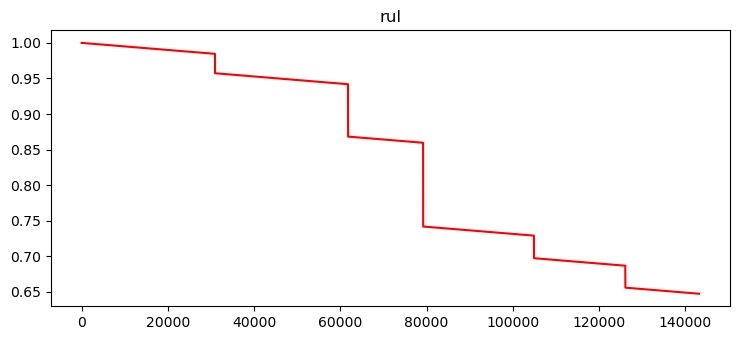

In [50]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("Line graph")
plt.title("rul")
plt.plot(range(0,len(y_train['rul'])),y_train['rul'], color="red")





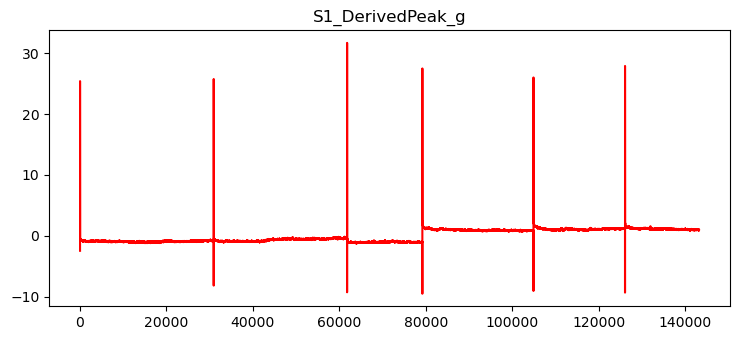

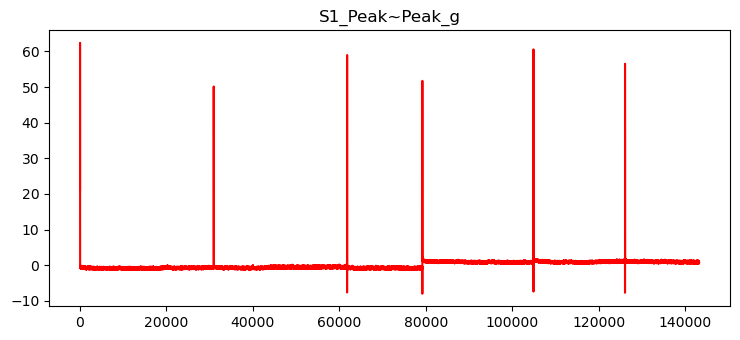

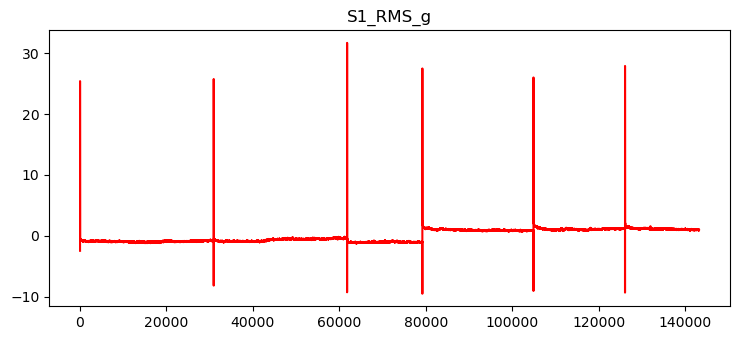

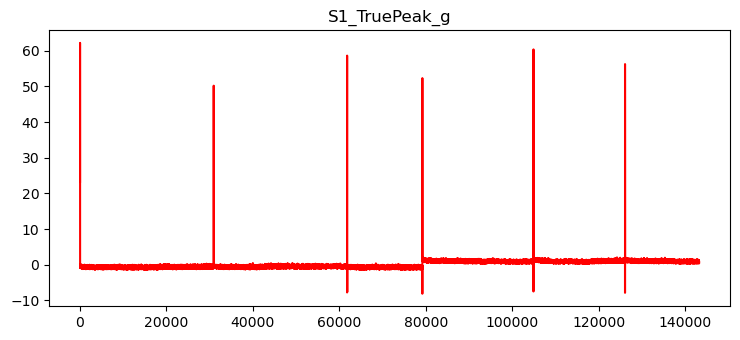

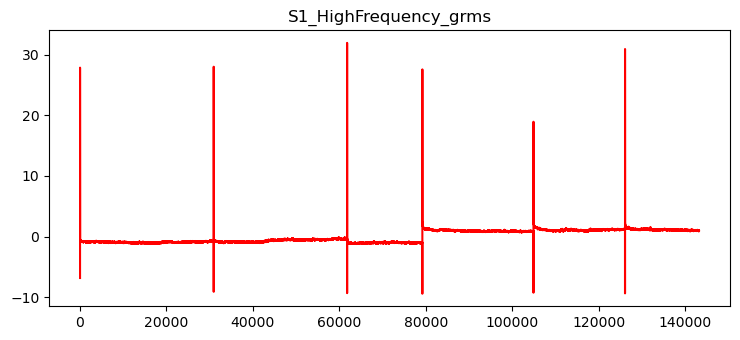

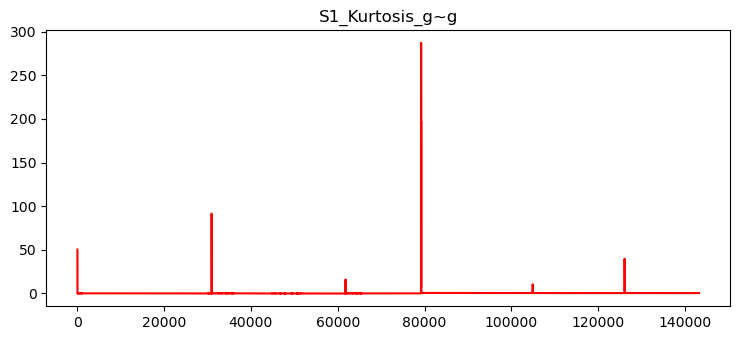

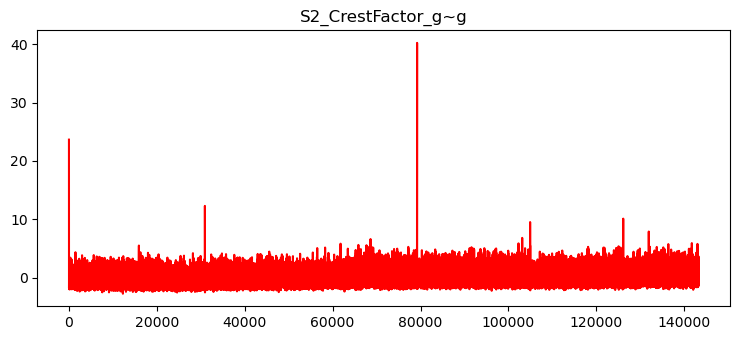

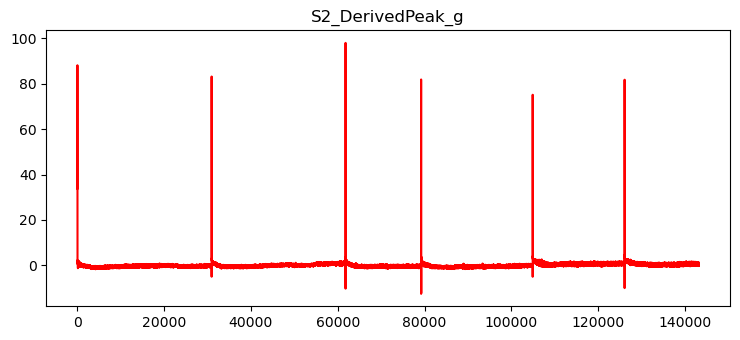

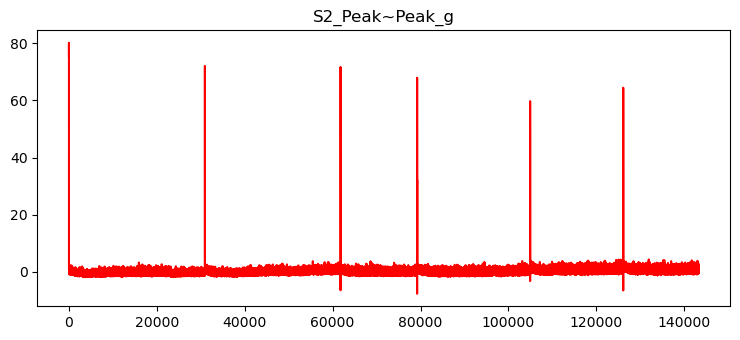

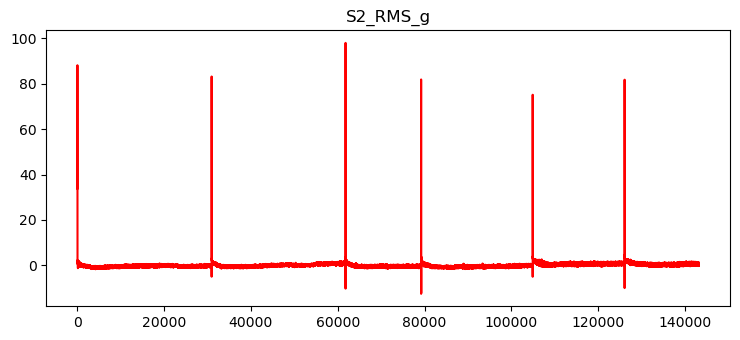

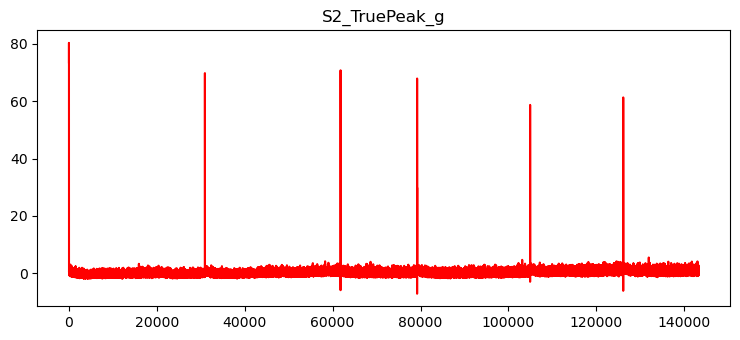

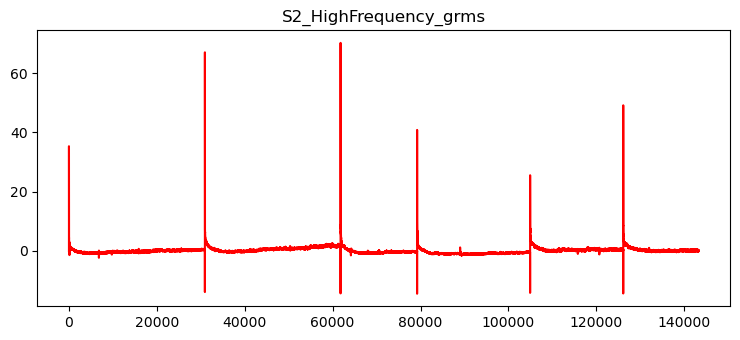

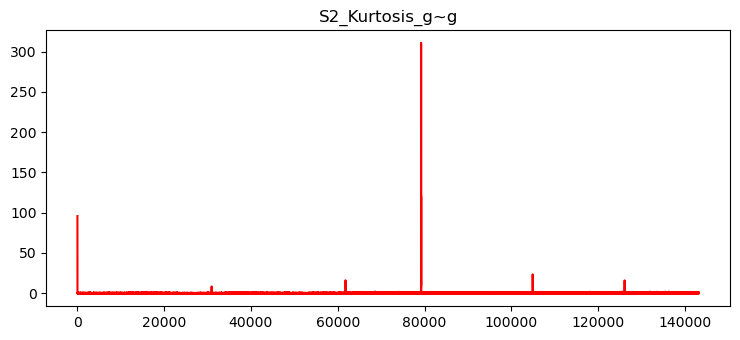

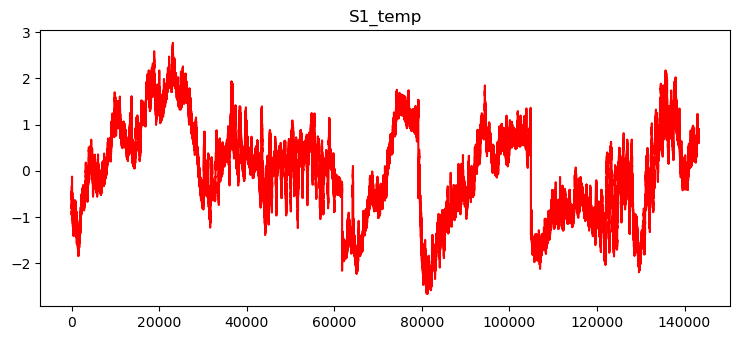

In [51]:

for i in X_train.columns[1:-1]:
    
    y=X_train[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()

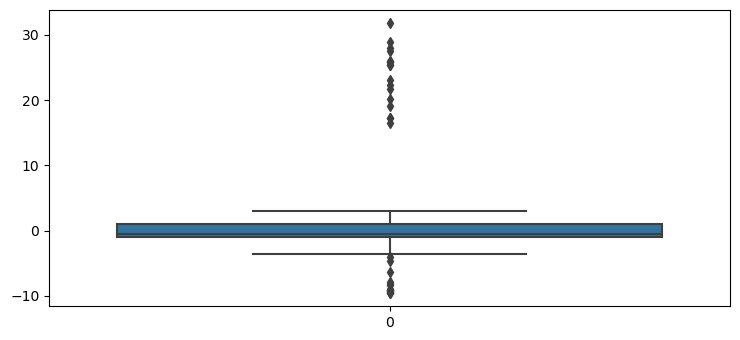

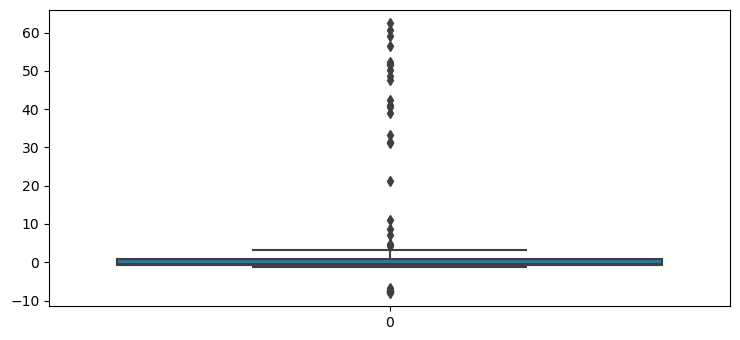

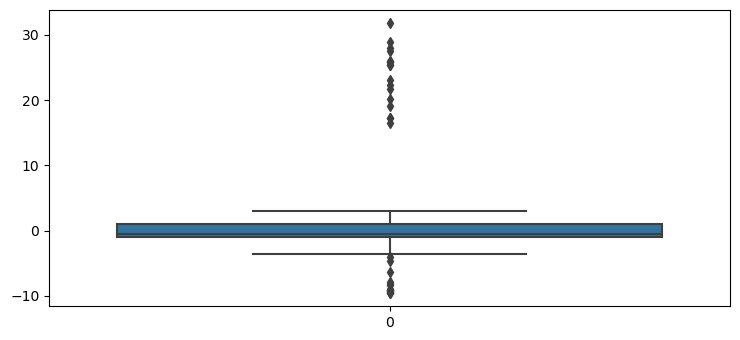

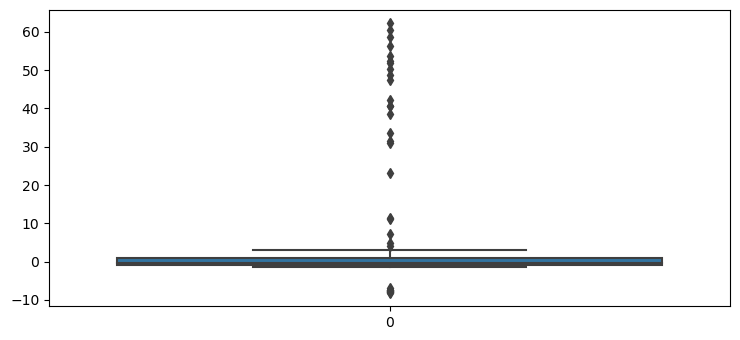

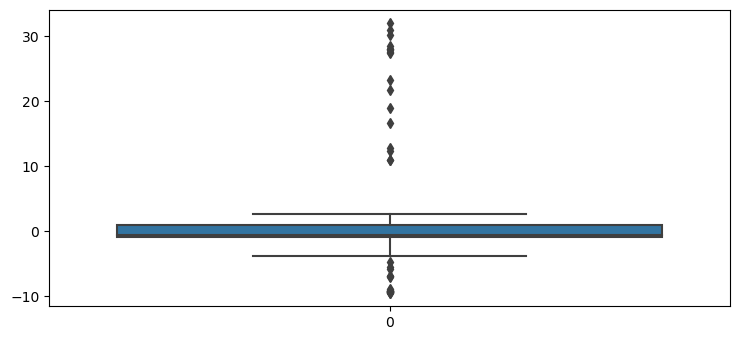

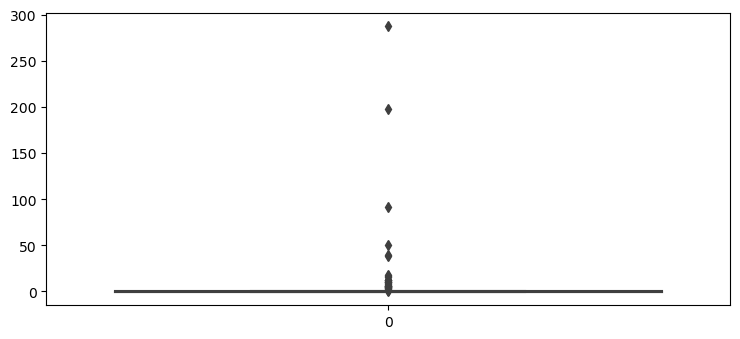

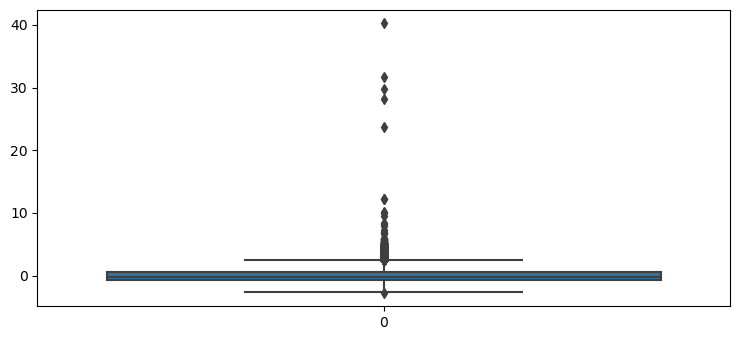

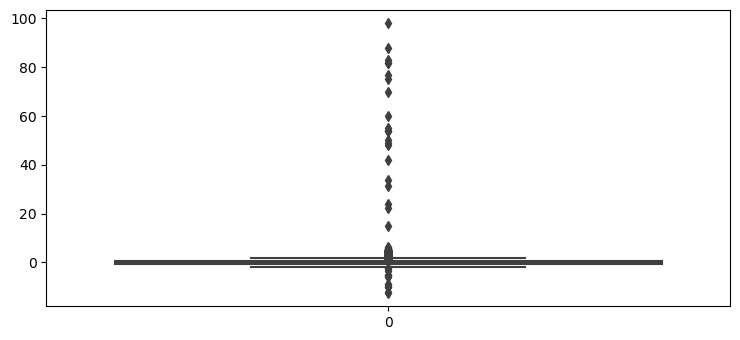

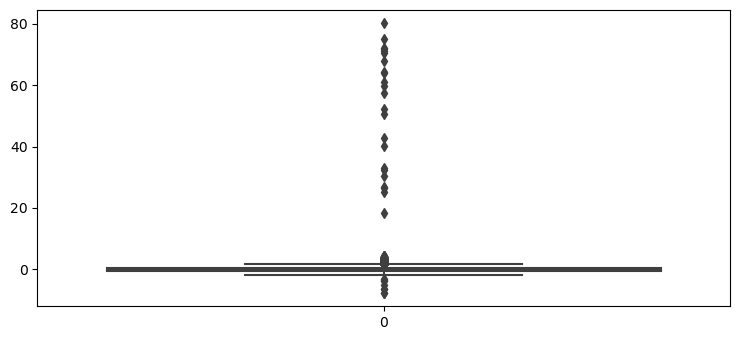

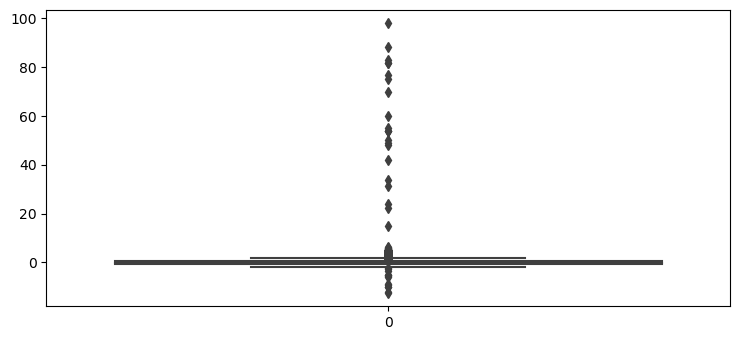

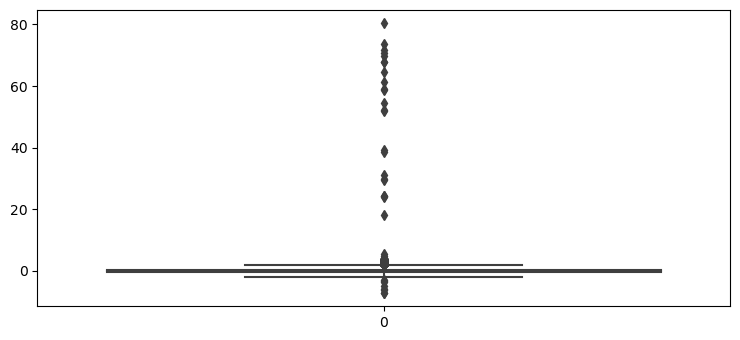

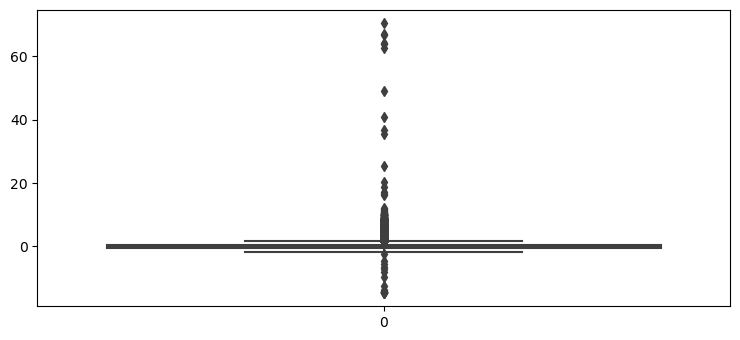

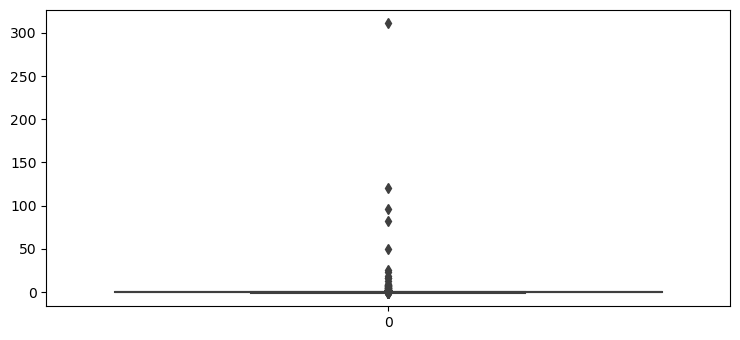

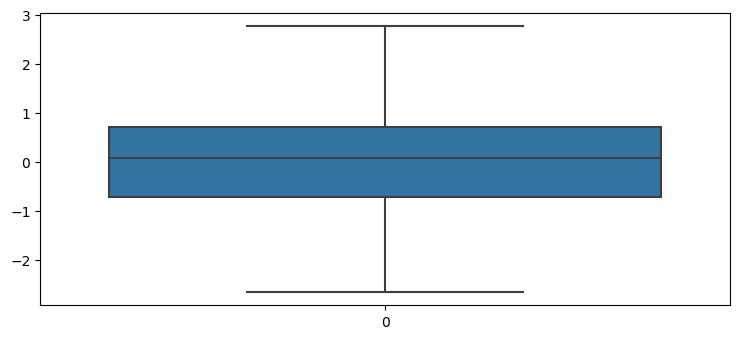

In [52]:

import seaborn as sns


for i in X_train.columns[1:-1]:
    
    y=X_train[[i]].values
    sns.boxplot(y)


    


#     x = range(0,len(y))

#     plt.title("Line graph")
#     plt.plot(x, y, color="red")
#     plt.title(str(i))

    plt.show()

In [57]:
import matplotlib.pyplot as plt
correlation_mat=np.corrcoef(X_train)


# taking all rows but only 6 columns
df_small = df.iloc[:,:6]
correlation_mat = df_small.corr()
sns.heatmap(correlation_mat, annot = True,)
plt.show()



KeyboardInterrupt: 

In [48]:
seq_length=200
#STEPS_PER_BATCH=#X_vals.shape[0]


###### LSTMs and Sequences:
LSTM models need 3 dimentional inputs (number of data rows, sequence_length, number of features). This because we need the LSTM to take a sequence of data (for example 60 mins of data) and from this sequence, we want the LSTM model to predict the RUL. These 3 inputs provide the LSTM model all the information about the tendancies and variations in the data for this period, which gives the LSTM model an idea about the state of the motor. This is a strength of LSTM models. They take a degradation period of the motor and determines how much the motor has degraded (percent of life left or RUL as a percent). 

For this RUL model we will take 60 minutes of data (sequence_length = 60). We can take more if we desire, but the more data we take the longer the computation time will be. The quality of the LSTM model's prediction will increase the more data (larger sequence_length) we take in, but the quality of prediction reaches a maximum limit to where it will not improve even if more data is taken in.

In [49]:
def gen_seq(data, seq_length, columns):
    L=[]
    n = data.shape[0]
    for i in range(0, n - seq_length):
        L.append(data[i:i+seq_length][columns].values)
    return(L)

###### Homogeneity of Sequences:
For LSTM models, the sequences should be homogeneous. To accomplish this, we generate the sequences depending on the category/day variable. We split each category to into sequences, and then join them into one array in the cells below (for train and test datasets).

(data, seq_length, columns):

data = train_data[train_data['category'] == id

seq_length = 60

columns = ["s1","s2","s3","s4","s5","s6","cycle"]

In [50]:
#INCLUSION OF STATUS

In [51]:
columns=df.columns[:-2]
columns

Index(['S1_CrestFactor_g~g', 'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g',
       'S1_TruePeak_g', 'S1_HighFrequency_grms', 'S1_Kurtosis_g~g',
       'S2_CrestFactor_g~g', 'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g',
       'S2_TruePeak_g', 'S2_HighFrequency_grms', 'S2_Kurtosis_g~g', 'S1_temp'],
      dtype='object')

In [52]:
columns.shape

(15,)

In [53]:
target=df.columns[-1]
target

'rul'

In [54]:
X_train.shape

(143232, 16)

In [55]:

train_inputs = np.concatenate(np.array([gen_seq(X_train[X_train['status'] == id], seq_length, columns)
                               for id in X_train['status'].unique()]))

/tmp/ipykernel_426802/3637815573.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_inputs = np.concatenate(np.array([gen_seq(X_train[X_train['status'] == id], seq_length, columns)


In [56]:
train_inputs.shape

(142832, 200, 15)

In [57]:

test_inputs = np.concatenate(np.array([gen_seq(X_test[X_test['status'] == id], seq_length, columns)
                               for id in X_test['status'].unique()]))

/tmp/ipykernel_426802/3385912461.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_inputs = np.concatenate(np.array([gen_seq(X_test[X_test['status'] == id], seq_length, columns)


In [58]:
test_inputs.shape

(47345, 200, 15)

In [59]:

vals_inputs = np.concatenate(np.array([gen_seq(X_vals[X_vals['status'] == id], seq_length, columns)
                               for id in X_vals['status'].unique()]))

/tmp/ipykernel_426802/4079337520.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vals_inputs = np.concatenate(np.array([gen_seq(X_vals[X_vals['status'] == id], seq_length, columns)


In [60]:
vals_inputs.shape

(47145, 200, 15)

In [61]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]

In [62]:
train_out = np.concatenate(np.array([gen_labels(y_train[y_train['status'] == id], seq_length, [target])
                               for id in y_train['status'].unique()]))

/tmp/ipykernel_426802/3860507962.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_out = np.concatenate(np.array([gen_labels(y_train[y_train['status'] == id], seq_length, [target])


In [63]:
train_out.shape


(142832, 1)

In [64]:
test_out = np.concatenate(np.array([gen_labels(y_test[y_test['status'] == id], seq_length, [target])
                               for id in y_test['status'].unique()]))

/tmp/ipykernel_426802/2787026141.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_out = np.concatenate(np.array([gen_labels(y_test[y_test['status'] == id], seq_length, [target])


In [65]:
test_out.shape

(47345, 1)

In [66]:
vals_out = np.concatenate(np.array([gen_labels(y_vals[y_vals['status'] == id], seq_length, [target])
                               for id in y_vals['status'].unique()]))

/tmp/ipykernel_426802/1340672247.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vals_out = np.concatenate(np.array([gen_labels(y_vals[y_vals['status'] == id], seq_length, [target])


In [67]:
vals_out.shape

(47145, 1)

In [80]:

# !rm -rf logs/fit/*
# !rm -rf /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/*


In [94]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es=EarlyStopping(
    monitor="val_loss",

    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.0001
)

filepath=path+'/checkpoint/RUL16LSTM/'+"weights-improvement-{epoch:02d}-{val_mae:.2f}.h5"

# fname = os.path.sep.join([filepath,args["weights"],"weights-{epoch:03d}-{val_loss:.4f}.h5"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_mae',

    mode='min',
    save_best_only=True, verbose=1)


# # checkpoint_filepath = "./tmp/checkpoint"

#scaler = MinMaxScaler()



logs/fit/20230601-160910


In [95]:
%load_ext tensorboard
%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Scheduler

In [99]:

# #TRAINING OLD MODEL
# tf.keras.backend.clear_session()


# nb_features = train_inputs.shape[2]
# sequence_length  = train_inputs.shape[1]
# nb_out = train_out.shape[1]

# model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(64, input_shape = (sequence_length, nb_features), return_sequences = True,kernel_regularizer=L2(0.01), recurrent_regularizer=L2(0.01)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(32,kernel_regularizer=L2(0.1), recurrent_regularizer=L2(0.01)),
#     tf.keras.layers.Dropout(0.2),

# # # hidden layers
# # Dense(40, activation="linear", input_dim=X_train.shape[1],kernel_regularizer=L1L2(l2=0.01,l1=0.01)), #Better

# # tf.keras.layers.Dropout(0.3),


# #     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(nb_out, activation = 'linear')
# ])

# model.compile(loss='huber', optimizer='adam', metrics=['mae'])








tf.keras.backend.clear_session()

nb_features = train_inputs.shape[2]
sequence_length  = train_inputs.shape[1]
nb_out = train_out.shape[1]

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape = (sequence_length, nb_features), return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nb_out, activation = 'relu')
])

lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-7 * 10**(epoch/3))

model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 10**-7), metrics =['mse','mae'])




2023-06-01 16:14:26.377109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 16:14:26.379415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 16:14:26.380483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [100]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 64)           20480     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 32,929
Trainable params: 32,929
Non-trainable params: 0
_________________________________________________________________


In [101]:
#FAST AI SEE IF TRIANING IMPROVES !
# 1420492
# history = model.fit(train_inputs, train_out, epochs = 20, callbacks = [lr])
history=model.fit(train_inputs,train_out,epochs=30,validation_data= (vals_inputs,vals_out) ,verbose=1,callbacks=[tensorboard_callback,lr,model_checkpoint_callback,es],)


Epoch 1/30


2023-06-01 16:14:33.044441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 16:14:33.045881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 16:14:33.046980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4460/4464 [============================>.] - ETA: 0s - loss: 0.2189 - mse: 0.4377 - mae: 0.6403

2023-06-01 16:15:37.130739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 16:15:37.132214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 16:15:37.133272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_mae improved from inf to 0.46905, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement-01-0.47.h5
4464/4464 [==============================] - 74s 16ms/step - loss: 0.2188 - mse: 0.4377 - mae: 0.6403 - val_loss: 0.1213 - val_mse: 0.2425 - val_mae: 0.4691 - lr: 1.0000e-07
Epoch 2/30
4462/4464 [============================>.] - ETA: 0s - loss: 0.1888 - mse: 0.3776 - mae: 0.5758
Epoch 2: val_mae improved from 0.46905 to 0.42457, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement-02-0.42.h5
4464/4464 [==============================] - 70s 16ms/step - loss: 0.1888 - mse: 0.3775 - mae: 0.5758 - val_loss: 0.1082 - val_mse: 0.2164 - val_mae: 0.4246 - lr: 2.1544e-07
Epoch 3/30
4461/4464 [============================>.] - ETA: 0s - loss: 0.1473 - mse: 0.2947 - mae: 0.4707
Epoch 3: val_mae improved from 0.42457 to 0.36924, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-impro

# No Scheduler

In [92]:
tf.keras.backend.clear_session()

nb_features = train_inputs.shape[2]
sequence_length  = train_inputs.shape[1]
nb_out = train_out.shape[1]

model = tf.keras.models.Sequential([
    # "1" 
    tf.keras.layers.LSTM(64, input_shape = (sequence_length, nb_features), return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    #"2"
    tf.keras.layers.Dense(nb_out, activation = 'relu')
])

model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 10**-7), metrics =['mse','mae'])
    # "3"
# history = model.fit(train_inputs, train_out, epochs = 120)


### "use a validation_split of 10% of the training data"
history = model.fit(train_inputs, train_out, validation_split=0.10, epochs = 150, verbose=1,callbacks=[tensorboard_callback,model_checkpoint_callback,es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

2023-06-01 16:05:35.788206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 16:05:35.791364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 16:05:35.792368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/150


2023-06-01 16:05:41.643960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 16:05:41.645514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 16:05:41.646652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4015/4018 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0051 - mae: 0.0474

2023-06-01 16:06:39.560368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 16:06:39.562218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 16:06:39.563270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_mae did not improve from 0.04002
4018/4018 [==============================] - 62s 15ms/step - loss: 0.0025 - mse: 0.0051 - mae: 0.0474 - val_loss: 0.0014 - val_mse: 0.0027 - val_mae: 0.0518
Epoch 2/150
4017/4018 [============================>.] - ETA: 0s - loss: 2.1035e-04 - mse: 4.2069e-04 - mae: 0.0148
Epoch 2: val_mae did not improve from 0.04002
4018/4018 [==============================] - 58s 14ms/step - loss: 2.1035e-04 - mse: 4.2070e-04 - mae: 0.0148 - val_loss: 0.0019 - val_mse: 0.0039 - val_mae: 0.0614
Epoch 3/150
4016/4018 [============================>.] - ETA: 0s - loss: 1.0281e-04 - mse: 2.0563e-04 - mae: 0.0108
Epoch 3: val_mae did not improve from 0.04002
4018/4018 [==============================] - 58s 14ms/step - loss: 1.0283e-04 - mse: 2.0566e-04 - mae: 0.0108 - val_loss: 0.0017 - val_mse: 0.0033 - val_mae: 0.0562
Epoch 4/150
1275/4018 [========>.....................] - ETA: 37s - loss: 9.9667e-05 - mse: 1.9933e-04 - mae: 0.0104

KeyboardInterrupt: 

# Brute Grid Model Search

Objective: + Low val_mae && + High Training Epochs 

In [ ]:
#OPTIMIZATION PARAMETERS

utc_time=[BEST_MODEL]# USE THE BEST RANDOM FOREST SAVED!!!!!!!! ADD IT AS A INTEGER
start_with_magicword = ['data/T18 50 percent radial immersion/']
FOLDS=[5] #KFOLD NUMBER OF FOLDS
THRESHOLD=[i for i in np.arange(0.05,0.15,0.05)] #[0.2,0.3,0.4,0.5,0.6,0.7,0.8] #FROM 0.1111 UP TO 0 0.9999
RATIO_THRESHOLD=[1.5,2,2.5] #HIGHER OR EQUAL THAN 1

In [ ]:
from typing import Iterable, Any
from itertools import product

def grid_parameters(parameters: dict[str, Iterable[Any]]) -> Iterable[dict[str, Any]]:
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))


parameters ={"FOLDS":FOLDS,"THRESHOLD":THRESHOLD,"RATIO_THRESHOLD":RATIO_THRESHOLD,"start_with_magicword":start_with_magicword,"utc_time":utc_time}
rfcs=[]
objectives=[]
for settings in grid_parameters(parameters):
    print(settings)
    # Some random fake model that needs learning_rate & penalty as arguments
    objective2,model2 = generalization_experiment(**settings)
    print("MODEL APPENDED")
    rfcs.append(model2)
    objectives.append(np.mean(objective2))
    print("NOTE RESUTLTS: ", np.mean(objective2))

In [ ]:

def optimizer():
    
    logger_dir = "logs/history/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    print(logger_dir)
    logger=tf.keras.callbacks.CSVLogger(logger_dir + ".csv", append=True)

    
    
    
    
    
    
    
    tf.keras.backend.clear_session()

    nb_features = train_inputs.shape[2]
    sequence_length  = train_inputs.shape[1]
    nb_out = train_out.shape[1]

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape = (sequence_length, nb_features), return_sequences = True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(nb_out, activation = 'relu')
    ])

    lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-7 * 10**(epoch/3))

    model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 10**-7), metrics =['mse','mae'])
    
    history=model.fit(train_inputs,train_out,epochs=30,validation_data= (vals_inputs,vals_out) ,verbose=1,callbacks=[lr,model_checkpoint_callback,es,logger],)
    
    
    
    #OPTIMIZATION VARIABLES!
    
    best_val_mae = min(hist.history['val_mae'])
    best_val_mae = min(hist.history['val_loss'])
    
    
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model train vs validation loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper right')
#     plt.show()
    
    

    return 


# Models Summary

Original : Tenosorboard Log 135911

DropOut to 0.2->0.3:Tenosorboard Log 144836

Best: Tenosorboard Log151330

# Testing

In [ ]:
# loading the saved modelweights-improvement-87-0.16.h /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement-07-0.04.h5
loaded_model = tf.keras.models.load_model('/home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement-01-0.04.h5')


In [90]:
_test_inputs=test_inputs[0:]
_test_out=test_out[0:]



y_pred = loaded_model.predict(_test_inputs) ## using the untinted dataset!
    
print('R^2:', metrics.r2_score(_test_out, y_pred))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(_test_out, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(_test_out, y_pred))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(_test_out, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(_test_out, y_pred))) # np.sqrt

print('Explained Variance Score:', metrics.explained_variance_score(_test_out, y_pred))
print('Max Error:', metrics.max_error(_test_out, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(_test_out, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(_test_out, y_pred))

## with n_estimators = 150

# R^2: 0.9991654290573937
# Mean Absolute Error (MAE): 1158.6216816072117
# Mean Squared Error (MSE): 333818221.94037396
# Root Mean Squared Error (RMSE): 18270.692979205083
# Explained Variance Score: 0.9991654316522736
# Max Error: 1998236.0866666667
# Mean Squared Log Error: 0.012717975468372306
# Median Absolute Error: 147.4266666667536

## n_estimators = 10
# R^2: 0.9990822069686238
# Mean Absolute Error (MAE): 1213.5715068447246
# Mean Squared Error (MSE): 367106044.79767376
# Mean Absolute Percentage Error (MAPE): 1.0690696275079867e+17
# Root Mean Squared Error (RMSE): 19160.011607451437
# Explained Variance Score: 0.9990822141398445
# Max Error: 1998818.5
# Mean Squared Log Error: 0.012296657672986336
# Median Absolute Error: 137.60000000009313

2023-06-01 15:54:57.535938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 15:54:57.537342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 15:54:57.538389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1480/1480 [==============================] - 9s 6ms/step
R^2: -30.112256200128243
Mean Absolute Error (MAE): 0.7526013430685545
Mean Squared Error (MSE): 0.5971201271532062
Mean Absolute Percentage Error (MAPE): 82309233891.59103
Root Mean Squared Error (RMSE): 0.7727354833015022
Explained Variance Score: -0.6001792738294198
Max Error: 1.0026101791434379
Mean Squared Log Error: 0.30006614936079357
Median Absolute Error: 0.6872188514039178


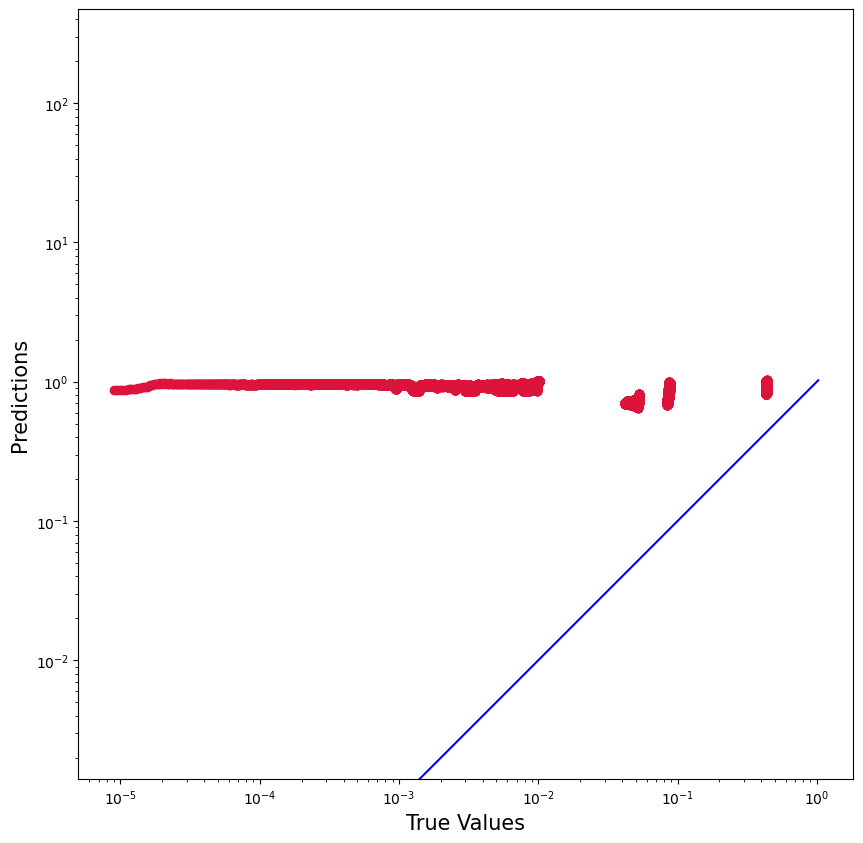

In [91]:
plt.figure(figsize=(10,10))
plt.scatter(_test_out, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(_test_out))
p2 = min(min(y_pred), min(_test_out))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# Model 2:


###### LSTMs and Sequences:
LSTM models need 3 dimentional inputs (number of data rows, sequence_length, number of features). This because we need the LSTM to take a sequence of data (for example 60 mins of data) and from this sequence, we want the LSTM model to predict the RUL. These 3 inputs provide the LSTM model all the information about the tendancies and variations in the data for this period, which gives the LSTM model an idea about the state of the motor. This is a strength of LSTM models. They take a degradation period of the motor and determines how much the motor has degraded (percent of life left or RUL as a percent). 

For this RUL model we will take 60 minutes of data (sequence_length = 60). We can take more if we desire, but the more data we take the longer the computation time will be. The quality of the LSTM model's prediction will increase the more data (larger sequence_length) we take in, but the quality of prediction reaches a maximum limit to where it will not improve even if more data is taken in.

In [56]:
train_data=pd.read_csv('/home/jose/FL_AM_Defect-Detection/DEC_DATA/train_data.csv',index_col=None)
test_data=pd.read_csv('/home/jose/FL_AM_Defect-Detection/DEC_DATA/test_data.csv',index_col=None)



In [57]:
train_data.head()

,RUL,category,cycle,s1,s2,s3,s4,s5,s6
0,1.000000,1.0,0.000000,0.484999,0.486861,0.370133,0.664457,0.322148,0.372222
1,0.999971,1.0,0.000029,0.631700,0.478878,0.592081,0.589890,0.431123,0.446895
2,0.999943,1.0,0.000057,0.671811,0.494505,0.475300,0.609210,0.426485,0.453126
3,0.999914,1.0,0.000086,0.578963,0.416925,0.515753,0.357859,0.484526,0.483112
4,0.999885,1.0,0.000115,0.494712,0.543916,0.483542,0.220499,0.539660,0.484685


# Lets Take a Look to the data!

In [58]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'RUL')

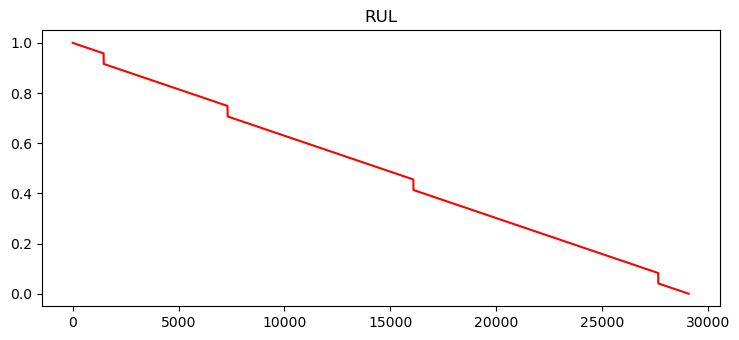

In [62]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("Line graph")
plt.plot(range(0,len(train_data['RUL'])),train_data['RUL'], color="red")
plt.title('RUL')


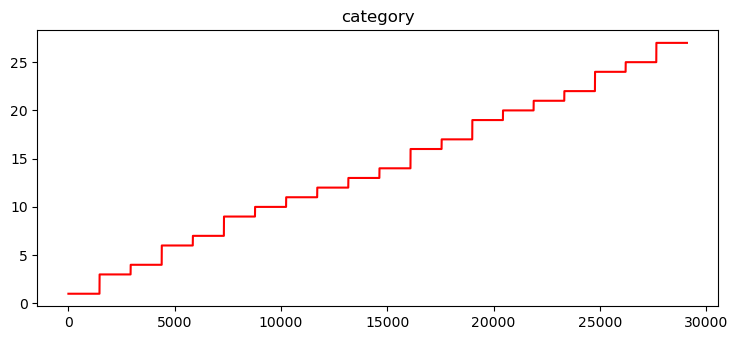

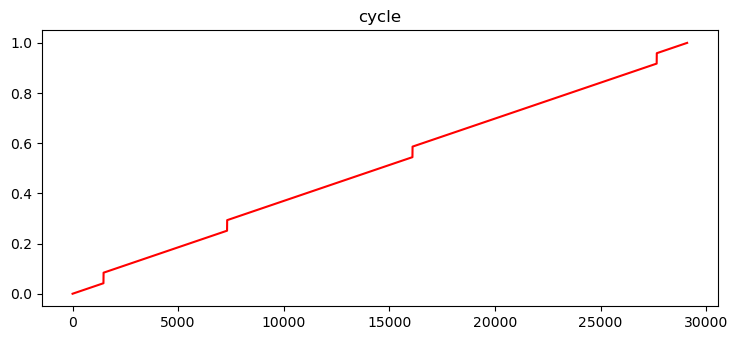

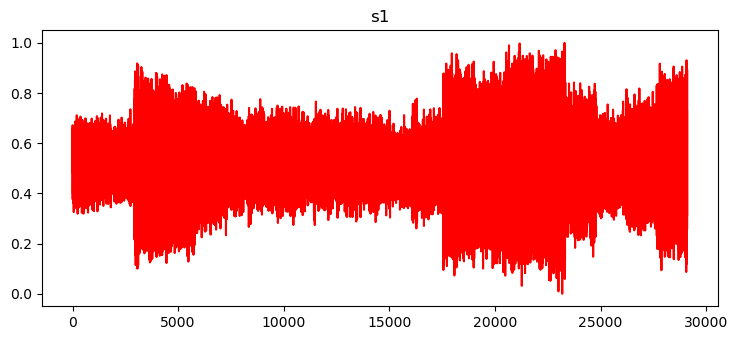

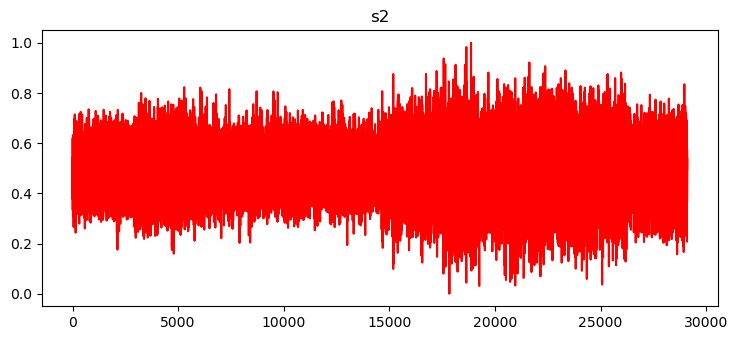

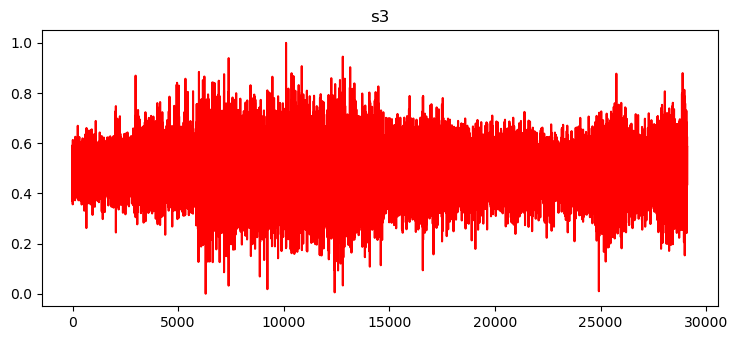

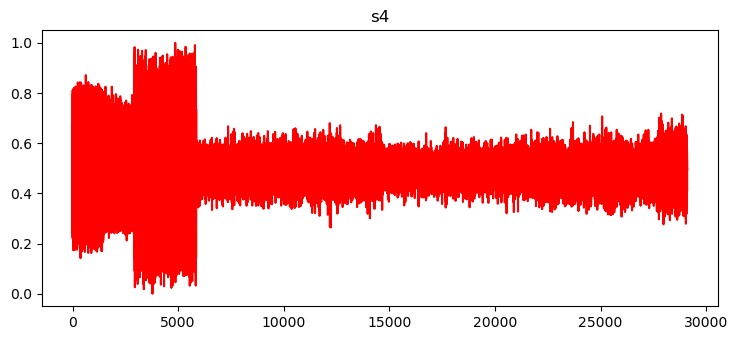

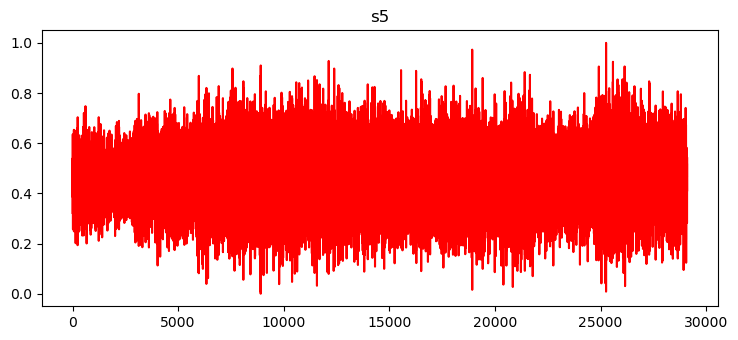

In [41]:
for i in train_data.columns[1:-1]:
    
    y=train_data[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()

In [83]:
test_data.head()

,RUL,category,cycle,s1,s2,s3,s4,s5,s6
0,0.958117,2.0,0.041883,0.469170,0.499443,0.546157,0.474688,0.484226,0.501690
1,0.958089,2.0,0.041911,0.572775,0.385471,0.482286,0.226137,0.410976,0.300687
2,0.958060,2.0,0.041940,0.601086,0.360348,0.627149,0.323045,0.507235,0.498465
3,0.958032,2.0,0.041968,0.648032,0.383242,0.469450,0.627174,0.440170,0.491110
4,0.958003,2.0,0.041997,0.592633,0.576027,0.517164,0.735063,0.384482,0.480431


In [ ]:
def gen_seq(data, seq_length, columns):
    L=[]
    n = data.shape[0]
    for i in range(0, n - seq_length):
        L.append(data[i:i+seq_length][columns].values)
    return(L)


###### Homogeneity of Sequences:
For LSTM models, the sequences should be homogeneous. To accomplish this, we generate the sequences depending on the category/day variable. We split each category to into sequences, and then join them into one array in the cells below (for train and test datasets).

(data, seq_length, columns):

data = train_data[train_data['category'] == id

seq_length = 60

columns = ["s1","s2","s3","s4","s5","s6","cycle"]



In [84]:
# train_inputs = np.concatenate(np.array([gen_seq(train_data[train_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6","cycle"])
#                                for id in train_data['category'].unique()]))

train_inputs = np.concatenate(np.array([gen_seq(train_data[train_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])
                               for id in train_data['category'].unique()]))

train_inputs.shape


/tmp/ipykernel_341703/1987298931.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_inputs = np.concatenate(np.array([gen_seq(train_data[train_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])


(27900, 60, 6)

In [85]:
# train_out

# train_inputs

# for i in range(len(train_inputs)):
#     x = train_inputs[i]
#     print('%s => %s' % (x))

# test_inputs = np.concatenate(np.array([gen_seq(test_data[test_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6","cycle"])
#                                for id in test_data['category'].unique()]))

test_inputs = np.concatenate(np.array([gen_seq(test_data[test_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])
                               for id in test_data['category'].unique()]))

test_inputs.shape


/tmp/ipykernel_341703/940717228.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_inputs = np.concatenate(np.array([gen_seq(test_data[test_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])


(5592, 60, 6)

In [86]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]


In [87]:

train_out = np.concatenate(np.array([gen_labels(train_data[train_data['category'] == id], 60, ["RUL"])
                               for id in train_data['category'].unique()]))

train_out.shape

/tmp/ipykernel_341703/2284794544.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_out = np.concatenate(np.array([gen_labels(train_data[train_data['category'] == id], 60, ["RUL"])


(27900, 1)

In [88]:


test_out = np.concatenate(np.array([gen_labels(test_data[test_data['category'] == id], 60, ["RUL"])
                               for id in test_data['category'].unique()]))

test_out.shape

/tmp/ipykernel_341703/418674133.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_out = np.concatenate(np.array([gen_labels(test_data[test_data['category'] == id], 60, ["RUL"])


(5592, 1)

In [97]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch, lr):
      if epoch < 40:
        lr=0.00001
        return lr
      else:
        lr=0.0001
        return lr #* tf.math.exp(-0.1)
lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

es=EarlyStopping(
    monitor="val_loss",

    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.0001
)

filepath=path+'/checkpoint/RULDECLSTM/'+"weights-improvement-{epoch:02d}-{val_mae:.2f}.h5"

# fname = os.path.sep.join([filepath,args["weights"],"weights-{epoch:03d}-{val_loss:.4f}.h5"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_mae',

    mode='min',
    save_best_only=True, verbose=1)


# # checkpoint_filepath = "./tmp/checkpoint"

#scaler = MinMaxScaler()



%load_ext tensorboard
%reload_ext tensorboard




# # Testing



# out_seq = np.array(y_test)#out_seq.reshape((len(out_seq), 1))
# # horizontally stack columns
# dataset = np.array(X_test)#hstack((in_seq1, in_seq2))

# pd.DataFrame(dataset)




# # shift the target sample by one step
# out_seq = np.insert(out_seq, 0, 0)
# #pre

# out_seq = np.delete(out_seq, -1)
# # define generator
# n_input = SEQUENCE_LENGHT #leght of the sequence timesteps
# testing_generator = TimeseriesGenerator(dataset, out_seq, length=n_input, batch_size=STEPS_PER_BATCH)
# # print each sample
# # for i in range(len(testing_generator)):
# #     x, y = generator[i]
# #     print('%s => %s' % (x, y))











tf.keras.backend.clear_session()

nb_features = train_inputs.shape[2]
sequence_length  = train_inputs.shape[1]
nb_out = train_out.shape[1]

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape = (sequence_length, nb_features), return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nb_out, activation = 'relu')
])

lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-7 * 10**(epoch/3))

model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 10**-7), metrics =['mse','mae'])

# # self.model
# model = Sequential()

# # hidden layers
# model.add(Dense(40, activation="relu", input_dim=X_train.shape[1],kernel_regularizer=L1L2(l2=0.01,l1=0.01))) #Better
# #GOOD 60

# model.add(Dropout(0.3))


# model.add(Dense(20, activation="relu",kernel_regularizer=L2(l2=0.001)))  #Better
# #GOOD 40
# model.add(Dropout(0.5))

# model.add(Dense(20, activation="linear"))

# # output layer
# model.add(Dense(1, activation="linear"))
# softmax for probability, #values are sigmoid


# Compile the network :
# NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
# NN_model.summary()

# Configure the model and start training
model.compile(loss='huber', optimizer='adam', metrics=['mae'])

model.summary()

# y_train
#50 and 30 -->
# R^2: 0.23383518186689745
# Mean Absolute Error (MAE): 396547.5620496487
# Mean Squared Error (MSE): 306771152615.1718
# Mean Absolute Percentage Error (MAPE): 3.5912102242185946e+17
# Root Mean Squared Error (RMSE): 553869.2558855129
# Explained Variance Score: 0.30378274542758565
# Max Error: 17869119.0
# Mean Squared Log Error: 2.760667782700153
# Median Absolute Error: 279682.8125






logs/fit/20230601-130857
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


2023-06-01 13:08:57.234611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:08:57.240234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:08:57.241397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            18176     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [98]:
#FAST AI SEE IF TRIANING IMPROVES !
# 1420492
# history = model.fit(train_inputs, train_out, epochs = 20, callbacks = [lr])
history=model.fit(train_inputs,train_out,epochs=30,validation_data= (test_inputs,test_out) ,verbose=1,callbacks=[tensorboard_callback,lr,model_checkpoint_callback,es],)


Epoch 1/30


2023-06-01 13:09:02.480312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:09:02.481865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:09:02.483092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

870/872 [============================>.] - ETA: 0s - loss: 0.1579 - mae: 0.4875

2023-06-01 13:09:11.964784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:09:11.966265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:09:11.967375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_mae improved from inf to 0.54123, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RULDECLSTM/weights-improvement-01-0.54.h5
872/872 [==============================] - 11s 9ms/step - loss: 0.1578 - mae: 0.4875 - val_loss: 0.2004 - val_mae: 0.5412 - lr: 1.0000e-07
Epoch 2/30
867/872 [============================>.] - ETA: 0s - loss: 0.1570 - mae: 0.4856
Epoch 2: val_mae did not improve from 0.54123
872/872 [==============================] - 6s 7ms/step - loss: 0.1570 - mae: 0.4856 - val_loss: 0.2004 - val_mae: 0.5412 - lr: 2.1544e-07
Epoch 3/30
865/872 [============================>.] - ETA: 0s - loss: 0.1526 - mae: 0.4766
Epoch 3: val_mae improved from 0.54123 to 0.54115, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RULDECLSTM/weights-improvement-03-0.54.h5
872/872 [==============================] - 6s 7ms/step - loss: 0.1525 - mae: 0.4764 - val_loss: 0.2004 - val_mae: 0.5411 - lr: 4.6416e-07
Epoch 4/30
871/872 [============================>.] 

In [102]:
### Saving model

model.summary()

# model.save(path+'MLP_REG_RUL_16',save_format='h5')



# loading the saved modelweights-improvement-87-0.16.h
loaded_model = tf.keras.models.load_model('/home/jose/FL_AM_Defect-Detection/checkpoint/RULDECLSTM/weights-improvement-16-0.08.h5')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            18176     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


2023-06-01 13:12:13.120451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:12:13.122616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:12:13.123690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [103]:
_test_inputs=test_inputs[0:]
_test_out=test_out[0:]



y_pred = loaded_model.predict(_test_inputs) ## using the untinted dataset!
    
print('R^2:', metrics.r2_score(_test_out, y_pred))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(_test_out, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(_test_out, y_pred))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(_test_out, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(_test_out, y_pred))) # np.sqrt

print('Explained Variance Score:', metrics.explained_variance_score(_test_out, y_pred))
print('Max Error:', metrics.max_error(_test_out, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(_test_out, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(_test_out, y_pred))

## with n_estimators = 150

# R^2: 0.9991654290573937
# Mean Absolute Error (MAE): 1158.6216816072117
# Mean Squared Error (MSE): 333818221.94037396
# Root Mean Squared Error (RMSE): 18270.692979205083
# Explained Variance Score: 0.9991654316522736
# Max Error: 1998236.0866666667
# Mean Squared Log Error: 0.012717975468372306
# Median Absolute Error: 147.4266666667536

## n_estimators = 10
# R^2: 0.9990822069686238
# Mean Absolute Error (MAE): 1213.5715068447246
# Mean Squared Error (MSE): 367106044.79767376
# Mean Absolute Percentage Error (MAPE): 1.0690696275079867e+17
# Root Mean Squared Error (RMSE): 19160.011607451437
# Explained Variance Score: 0.9990822141398445
# Max Error: 1998818.5
# Mean Squared Log Error: 0.012296657672986336
# Median Absolute Error: 137.60000000009313


2023-06-01 13:12:14.297030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:12:14.298515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:12:14.299597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

175/175 [==============================] - 1s 3ms/step
R^2: 0.9122389967444604
Mean Absolute Error (MAE): 0.08014411947907403
Mean Squared Error (MSE): 0.009466243663007943
Mean Absolute Percentage Error (MAPE): 0.5096658311603095
Root Mean Squared Error (RMSE): 0.09729462299124214
Explained Variance Score: 0.9162248820313804
Max Error: 0.35256587939942063
Mean Squared Log Error: 0.004816542903573396
Median Absolute Error: 0.06776273983800063


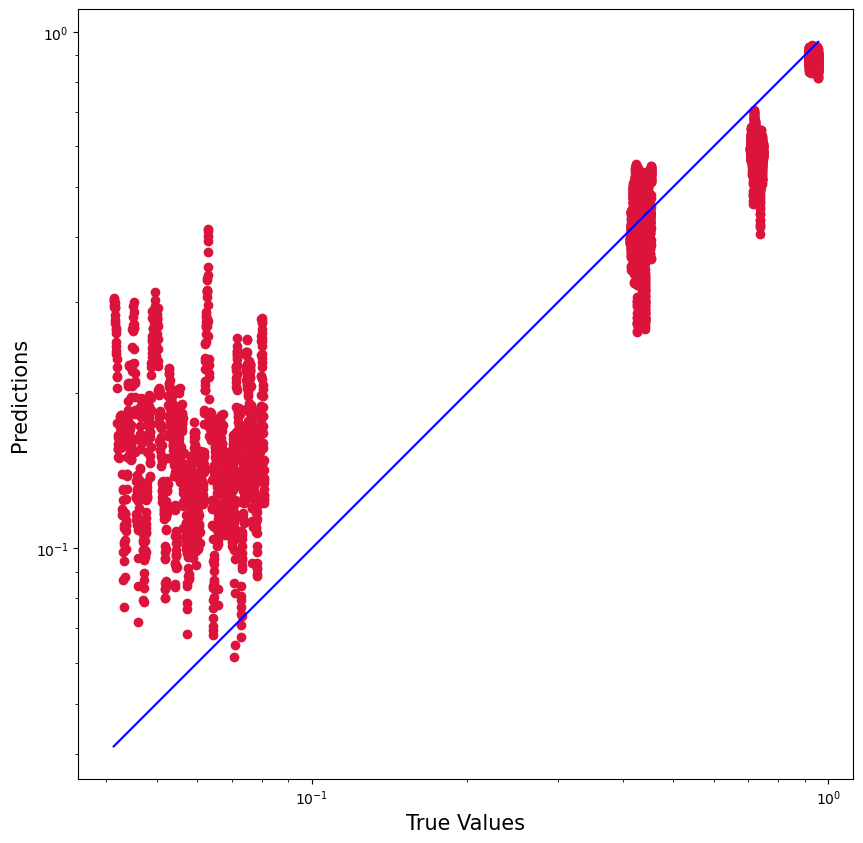

In [104]:

plt.figure(figsize=(10,10))
plt.scatter(_test_out, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(_test_out))
p2 = min(min(y_pred), min(_test_out))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()